In [1]:
# source ../../venv/kaggle/Scripts/activate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

In [3]:
PATH = "../data/"
COLUMNS = [
    "warehouse",
    "orders",
]
TARGET_COLUMN = "orders"
warehouse = [
    "Prague_1",
    "Brno_1",
    "Prague_2",
    "Prague_3",
    "Munich_1",
    "Frankfurt_1",
    "Budapest_1",
][3]
df = pd.read_csv(f"{PATH}train.csv", parse_dates=["date"], index_col=["date"])[
    COLUMNS
].query(f'warehouse=="{warehouse}"')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1193 entries, 2020-12-05 to 2024-03-15
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   warehouse  1193 non-null   object 
 1   orders     1193 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.0+ KB


In [4]:
df.head()

,warehouse,orders
date,,
2020-12-05,Prague_3,4091.0
2020-12-06,Prague_3,3972.0
2020-12-07,Prague_3,3903.0
2020-12-08,Prague_3,3684.0
2020-12-09,Prague_3,4063.0


Text(0.5, 0, 'Date')

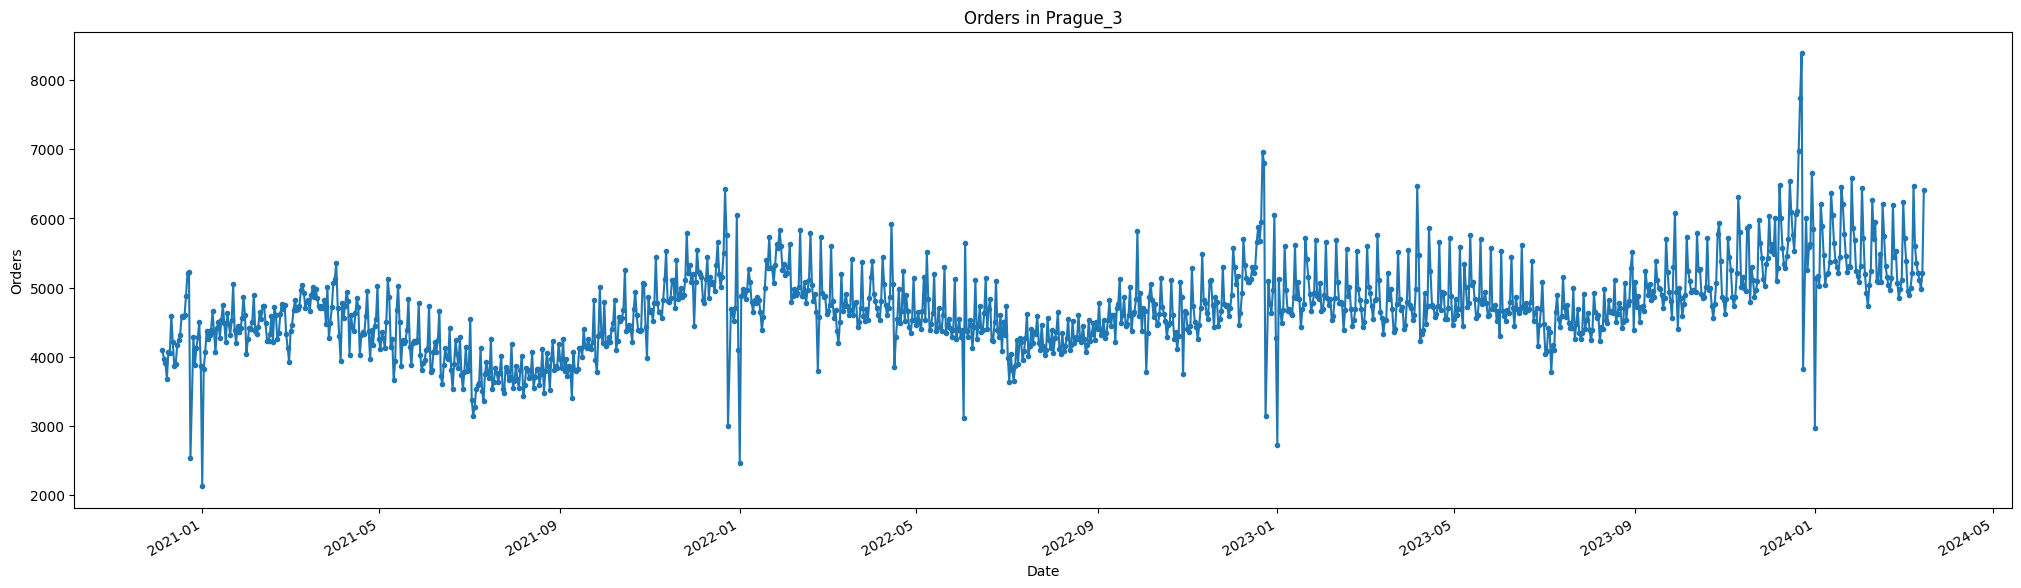

In [5]:
fig, ax = plt.subplots(figsize=[25, 7])

ax = df.plot(y=TARGET_COLUMN, marker=".", figsize=[25, 7], legend=None, ax=ax)
ax.set_title(f"Orders in {warehouse}")
ax.set_ylabel("Orders")
ax.set_xlabel("Date")

In [6]:
df_ = df.copy()
lag = 1
df_[f"{TARGET_COLUMN}_lag_{lag}"] = df_[TARGET_COLUMN].shift(periods=lag)
df_.head()

,warehouse,orders,orders_lag_1
date,,,
2020-12-05,Prague_3,4091.0,NaN
2020-12-06,Prague_3,3972.0,4091.0
2020-12-07,Prague_3,3903.0,3972.0
2020-12-08,Prague_3,3684.0,3903.0
2020-12-09,Prague_3,4063.0,3684.0


In [7]:
lag_transformer_day = LagFeatures(variables=[TARGET_COLUMN], freq=["1D", "7D"])
lag_transformer_month = LagFeatures(variables=[TARGET_COLUMN], freq=["1ME"])
lag_transformer_year = LagFeatures(variables=[TARGET_COLUMN], freq=["1Y"])
df_ = lag_transformer_day.fit_transform(df)
df_ = lag_transformer_month.fit_transform(df_)
# df_ = lag_transformer_year.fit_transform(df_)

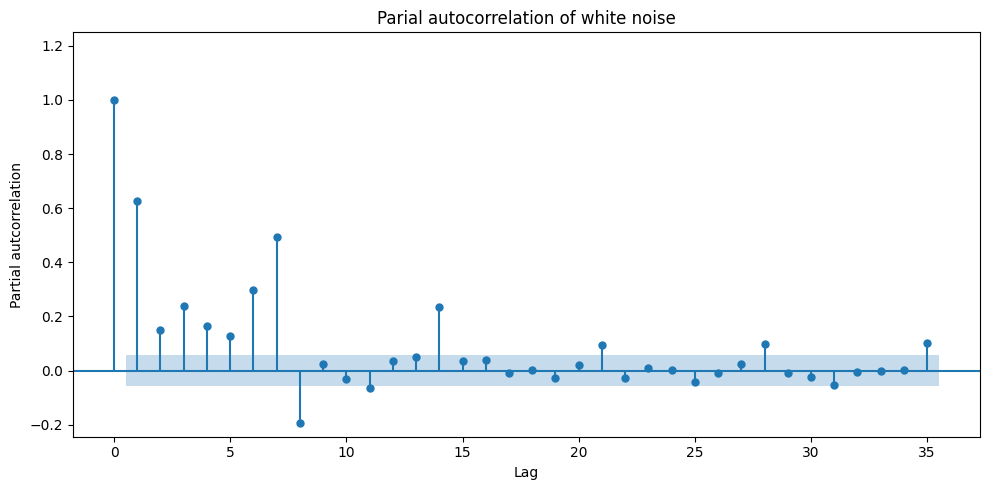

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=df[TARGET_COLUMN], method="ywmle", lags=35, ax=ax, alpha=0.05, auto_ylims=True
)
ax.set_title("Parial autocorrelation of white noise")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

<Axes: xlabel='date'>

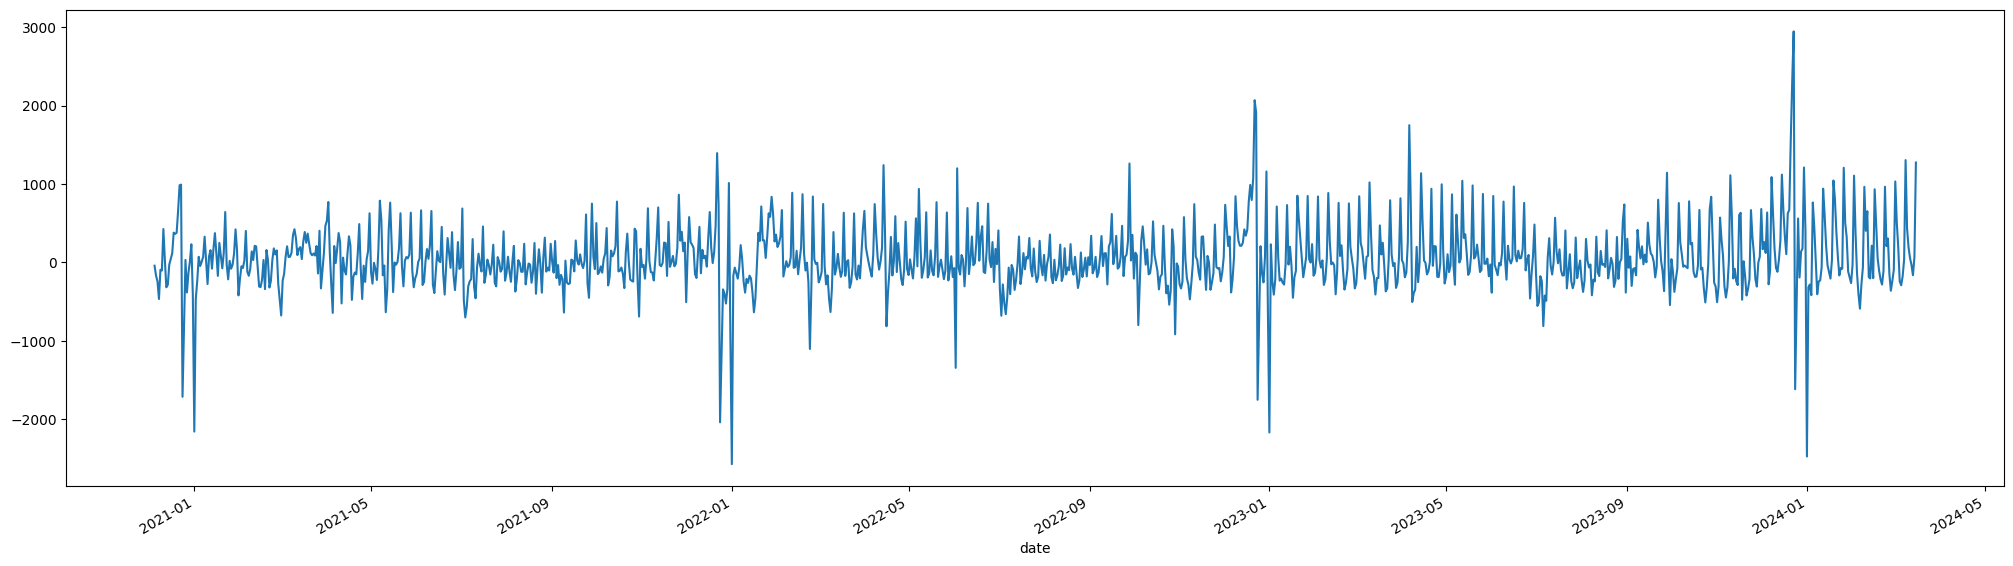

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Compute the trend with LOWESS
frac = 0.1
y = df[TARGET_COLUMN]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

df["y_detrend"] = df[TARGET_COLUMN] - df["lowess"]
df["y_detrend"].plot(figsize=(25, 7))

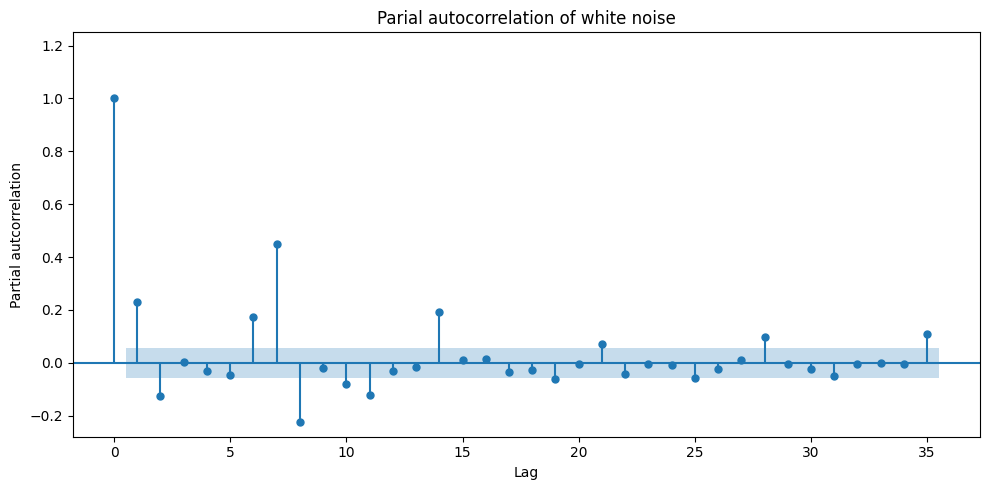

In [10]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_pacf(
    x=df["y_detrend"], method="ywmle", lags=35, ax=ax, alpha=0.05, auto_ylims=True
)
ax.set_title("Parial autocorrelation of white noise")
ax.set_ylabel("Partial autcorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

In [11]:
from statsmodels.tsa.stattools import pacf

pacf_ = pacf(df["y_detrend"], nlags=370)
dct = {k: v for k, v in zip(range(0, len(pacf_) + 1), list(pacf_))}
dct_ = {
    key: value
    for key, value in sorted(dct.items(), key=lambda item: abs(item[1]), reverse=True)
}

In [12]:
{k: v for k, v in dct_.items() if v > 0.1}

{0: np.float64(1.0),
 7: np.float64(0.45224076035790073),
 364: np.float64(0.42586676877707985),
 357: np.float64(0.31228288667376297),
 1: np.float64(0.2302427979930788),
 14: np.float64(0.19486032226080435),
 363: np.float64(0.19120084477361748),
 6: np.float64(0.17589655484913458),
 35: np.float64(0.11328683216272253),
 321: np.float64(0.10346307972506312)}

# Conclusion


After conducting the analysis on the dataset, it has been determined that the most important lag variables for predicting the target variable "orders" are lag1, lag7, and lag1year. These lag variables have shown significant correlation with the target variable and can provide valuable insights for forecasting future values. By considering these lag variables in the predictive models, we can improve the accuracy and reliability of our predictions. Therefore, it is recommended to include lag1, lag7, and lag1year as key features in any forecasting or predictive modeling tasks related to the "orders" variable.
